<a href="https://colab.research.google.com/github/KelvinLam05/Predicting-customer-lifetime-value-using-the-Pareto-NBD-model-and-Gamma-Gamma-model/blob/main/Modelling_Customers_Lifetime_Value_For_Non_Contractual_Business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

The aim of this project will be to perform a customer lifetime value analysis.

**Data set information**

Detailed data on sales of consumer goods obtained by ‘scanning’ the bar codes for individual products at electronic points of sale in a retail store. The data provide detailed information about quantities, characteristics and values of goods sold as well as their prices.

The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year.

**Attribute information**

* Date of Sales Transaction

* Customer ID

* Transaction ID

* SKU Category ID

* SKU ID

* Quantity Sold

* Sales Amount

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/scanner_data.csv')

In [ ]:
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [ ]:
df['Date'] = df['Date'].apply(pd.to_datetime)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      131706 non-null  int64         
 1   Date            131706 non-null  datetime64[ns]
 2   Customer_ID     131706 non-null  int64         
 3   Transaction_ID  131706 non-null  int64         
 4   SKU_Category    131706 non-null  object        
 5   SKU             131706 non-null  object        
 6   Quantity        131706 non-null  float64       
 7   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 8.0+ MB


In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

Sales_Amount      0
Quantity          0
SKU               0
SKU_Category      0
Transaction_ID    0
Customer_ID       0
Date              0
Unnamed: 0        0
dtype: int64

In [ ]:
cols_of_interest = ['Customer_ID', 'Sales_Amount', 'Date']

In [ ]:
df = df[cols_of_interest]

In [ ]:
df.head()

,Customer_ID,Sales_Amount,Date
0,2547,3.13,2016-02-01
1,822,5.46,2016-02-01
2,3686,6.35,2016-02-01
3,3719,5.59,2016-02-01
4,9200,6.88,2016-02-01


In [ ]:
print(df['Customer_ID'].nunique())

22625


There are 22,625 customers under our analysis.

For the CLV models, the following nomenclature is used:

* Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.

* T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

* Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [ ]:
df['Date'].max()

Timestamp('2016-12-31 00:00:00')

In [ ]:
# Calculate the raw recency, frequency, and monetary metrics
df_rfmt = summary_data_from_transaction_data(df, 'Customer_ID', 'Date', 'Sales_Amount', observation_period_end = '2016-12-31')

In [ ]:
df_rfmt.head()

,frequency,recency,T,monetary_value
Customer_ID,,,,
1,0.0,0.0,344.0,0.0000
2,1.0,87.0,282.0,15.0000
3,0.0,0.0,334.0,0.0000
4,1.0,57.0,111.0,6.6900
5,4.0,193.0,313.0,14.6725


Customer_ID 1 made 1 purchase only (no repeat), so his frequency and recency are 0, and his age is 76 days (e.g. the duration between his first purchase and the end of the period in the analysis).

In [ ]:
print(df_rfmt['frequency'].describe())
print(sum(df_rfmt['frequency'] == 0)/ float(len(df_rfmt)))

count    22625.000000
mean         1.772464
std          3.766669
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         76.000000
Name: frequency, dtype: float64
0.5241546961325967


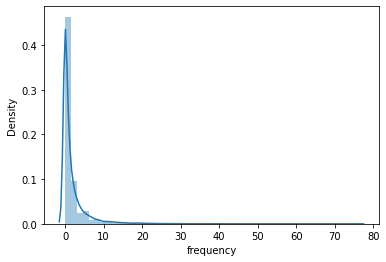

In [ ]:
ax = sns.distplot(df_rfmt['frequency'])

Among all customers in our data, more than 52% of them only made purchase once  (no repeat).

**Basic Frequency/Recency analysis using the BG/NBD model**

In [ ]:
bgf = BetaGeoFitter(penalizer_coef = 0)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'], tol = 1e-6)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.444132,0.007045,0.430324,0.457940
alpha,51.948589,1.100228,49.792142,54.105037
a,0.164658,0.014057,0.137107,0.192209
b,1.429004,0.160691,1.114050,1.743958


**Visualizing the Frequency/Recency Matrix**

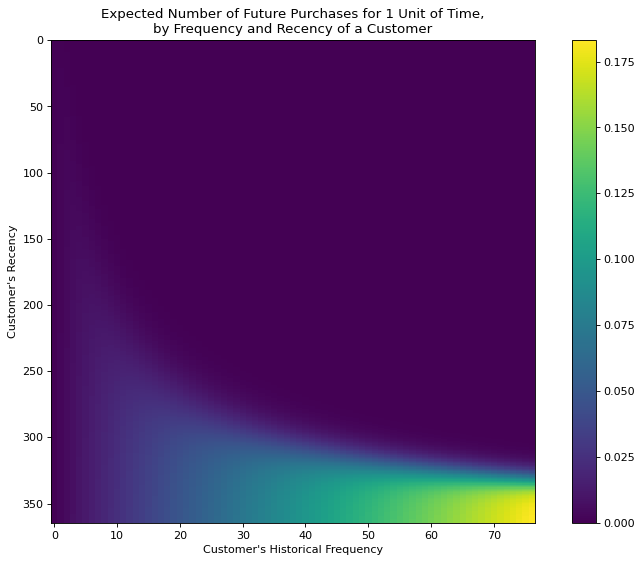

In [ ]:
figure(num = None, figsize = (12, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 70 times from you, and their latest purchase was when they were 350 days old (i.e. Recency: the duration between their first transaction and their latest transaction is 350 days), then they are our best customer (bottom-right). Our coldest customers
are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

There’s also that beautiful “tail” around (10, 250). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

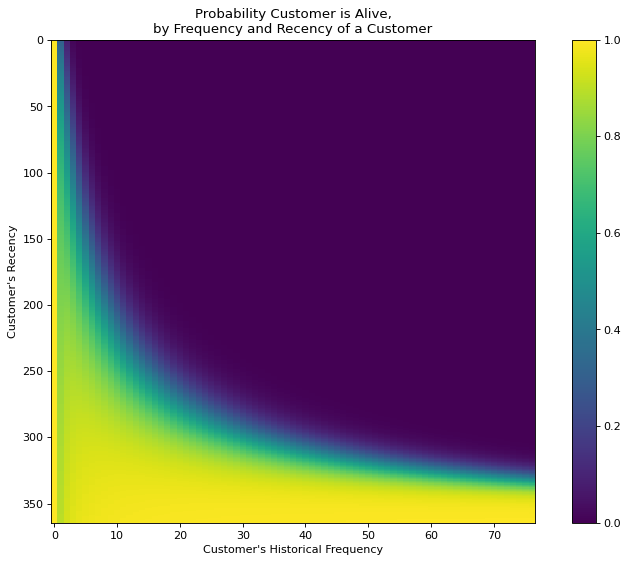

In [ ]:
figure(num = None, figsize = (12, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plot_probability_alive_matrix(bgf)

**Ranking customers from best to worst**

In [ ]:
t = 1
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])

In [ ]:
df_rfmt.sort_values(by = 'predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer_ID,,,,,
15685,58.0,345.0,355.0,25.722069,0.141875
1685,65.0,352.0,362.0,21.250769,0.156119
1665,71.0,362.0,364.0,25.679718,0.171171
1710,71.0,356.0,358.0,18.347746,0.173673
1660,76.0,361.0,361.0,18.609342,0.184683


Listed above are our top 5 customers that the model expects them to make purchases in the next day. The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

**Assessing model fit**

Ok, we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare the data versus artificial data simulated with the fitted
model’s parameters.

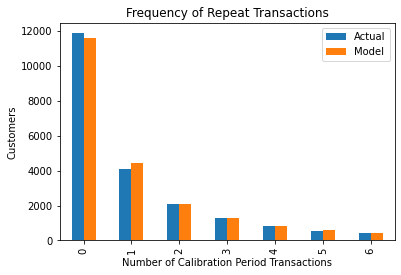

In [ ]:
# Assessing model fit
plot_period_transactions(bgf)

We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck. So, we can continue on with our analysis.

**More model fitting**

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is
important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine
learning literature). Lifetimes has a function to partition our dataset like this:

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer_ID', 'Date', calibration_period_end = '2016-06-01', observation_period_end = '2016-12-31')

In [ ]:
summary_cal_holdout.sort_values(by = 'frequency_holdout', ascending = False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
1660,28.0,147.0,148.0,48.0,213.0
1710,24.0,144.0,145.0,47.0,213.0
2186,8.0,125.0,145.0,46.0,213.0
15685,14.0,131.0,142.0,44.0,213.0
1665,27.0,150.0,151.0,44.0,213.0


With this dataset, we can perform fitting on the _cal columns, and test on the holdout columns:

In [ ]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'], tol = 1e-6)

<lifetimes.BetaGeoFitter: fitted with 13708 subjects, a: 0.88, alpha: 51.91, b: 10.94, r: 0.57>

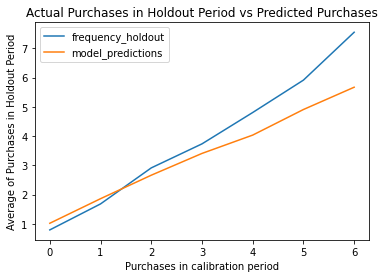

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

As we can see, our model over-estimates at 1 purchases and under-estimates at 2 purchases. The BG/NBD model is really good at predicting the number of orders customers will make over longer periods, but obviously this is tougher for shorter durations.

**Customer Predictions**

Based on customer history, we can predict what an individuals future purchases might look like:

In [ ]:
# Predict purchases in 120 periods
t = 120
individual = df_rfmt.iloc[1]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.41509403962283403

The customer in index 1 should place 0.42 orders in the next 120 days.

**Customer Probability Histories**

If we look at customer 9048 from our original dataset, we can see that they’ve placed 99 orders since they were first acquired on 2016-01-13 about 353 days ago. Most of their orders are pretty small, but they come back regularly.

In [ ]:
example_customer_orders = df.loc[df['Customer_ID'] == 9048]

In [ ]:
example_customer_orders

,Customer_ID,Sales_Amount,Date
3849,9048,14.09,2016-01-13
4343,9048,4.32,2016-01-14
5450,9048,12.20,2016-01-18
5705,9048,3.33,2016-01-18
7376,9048,22.79,2016-01-22
...,...,...,...
129824,9048,2.36,2016-07-29
129825,9048,13.58,2016-07-29
129826,9048,3.85,2016-07-29
129827,9048,14.37,2016-07-29


Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

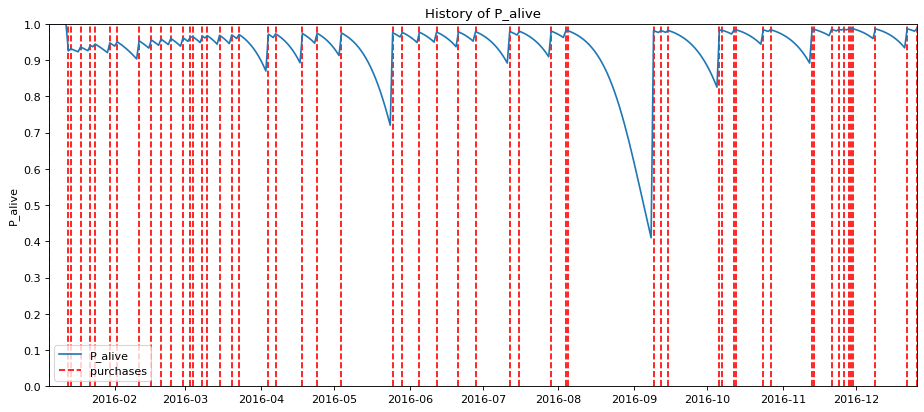

In [ ]:
# Plot customer probability history
figure(num = None, figsize = (14, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
days_since_birth = 353
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'Date')

Our best customer is definitely alive, however, he had one hiatus in the second half of the year 2016.

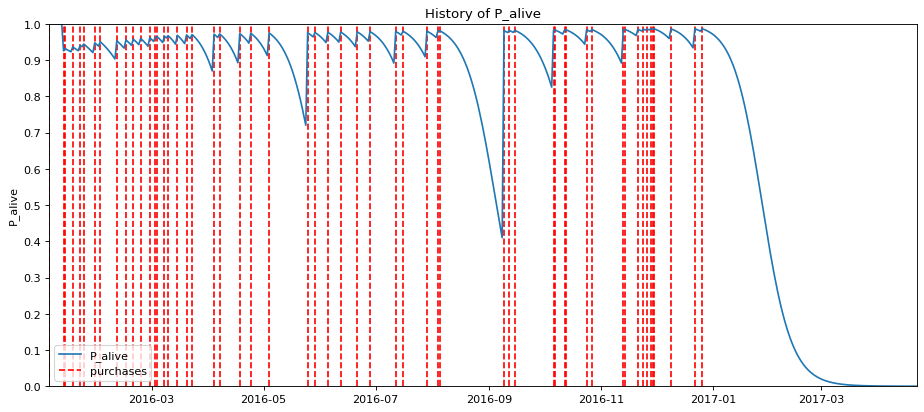

In [ ]:
figure(num = None, figsize = (14, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
days_since_birth = 473
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'Date')

If we now change the days_since_birth value from the actual length of their tenure (353 days) to a longer period, we’ll see how their probability of being alive plummets. If they don’t order again before the first quarter of 2017, the chances of them being alive are very slim. Either that, or they’re a seasonal customer and they might come back again next year.

In [ ]:
returning_customers = df_rfmt[df_rfmt['frequency'] > 0]
returning_customers = df_rfmt[df_rfmt['monetary_value'] > 0]
returning_customers.sort_values(by = 'monetary_value', ascending = False).head()

,frequency,recency,T,monetary_value,predicted_purchases
Customer_ID,,,,,
20906,2.0,249.0,360.0,593.94,0.005176
551,1.0,16.0,348.0,432.84,0.001450
19732,1.0,60.0,131.0,384.67,0.006393
3316,1.0,4.0,352.0,367.41,0.001191
5825,1.0,83.0,261.0,358.47,0.003323


We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 10,766 customers.

In [ ]:
print(len(returning_customers))

10766


**The Gamma-Gamma model and the independence assumption**

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which
relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship
between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation
between the two vectors is close to 0 in order to use this model.

In [ ]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.058109
frequency,0.058109,1.000000


**Estimating customer lifetime value using the Gamma-Gamma model**

In [ ]:
from lifetimes import GammaGammaFitter

At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)

In [ ]:
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 10766 subjects, p: 2.23, q: 2.55, v: 17.59>

We can now estimate the average transaction value:

In [ ]:
predicted_monetary = ggf.conditional_expected_average_profit(returning_customers['frequency'], returning_customers['monetary_value'])

In [ ]:
predicted_monetary.head()

Customer_ID
2     19.221344
4     14.320295
5     16.245331
13    23.892381
14    87.589236
dtype: float64

In [ ]:
print('Expected conditional average profit: %s, Average profit: %s' % (
ggf.conditional_expected_average_profit(returning_customers['frequency'], returning_customers['monetary_value']).mean(), returning_customers[returning_customers['frequency'] > 0]['monetary_value'].mean()))

Expected conditional average profit: 25.06270369583754, Average profit: 24.604821083366144


Finally, we’ll get to the good bit - predicting Customer Lifetime Value. To do this we’ll use both models - the BG/NBD model to predict the number of orders and the Gamma-Gamma model to predict their values. First we’ll re-fit the BetaGeoFitter BG/NBD model to our dataset for the returning customers, which includes the monetary data.

In [ ]:
# Refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers['frequency'], returning_customers['recency'], returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 10766 subjects, a: 0.20, alpha: 132.63, b: 0.72, r: 2.47>

Next, we will use the Gamma-Gamma model’s customer_lifetime_value ( ) function to predict their value. We’ll pass in the bgf model, along with the recency, frequency, monetary_value, and T data for each customers. The time parameter is in months and defines how many months into the future we wish to predict.

In [ ]:
preds = ggf.customer_lifetime_value(bgf, returning_customers['frequency'], returning_customers['recency'], returning_customers['T'], returning_customers['monetary_value'], time = 12, discount_rate = 0.01)
preds = preds.to_frame().reset_index()

If you sort the dataframe in descending order of the predicted CLV, you’ll see who the model predicts your best customers to be over the next 12 months. 

In [ ]:
preds.sort_values(by='clv', ascending = False).head()

,Customer_ID,clv
8104,17104,2576.303636
8417,17471,2557.344356
8267,17294,2554.155906
7001,15540,1886.894642
7112,15677,1719.668748
